<a href="https://colab.research.google.com/github/chowdhury27mykh-cell/OPERATING-SYSTEM/blob/main/OS_RTV_PROCESS_ALLOCATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#1) Imports and data loading
import pandas as pd
import numpy as np

# Load the CSVs
device_df   = pd.read_csv("/content/iot_device_memory_capacities.csv")
static_df   = pd.read_csv("/content/iot_static_memory_profiles.csv")
dynamic_df  = pd.read_csv("/content/iot_dynamic_memory_requests.csv")   # long trace
dynamic_100 = pd.read_csv("/content/iot_memory_requests_100.csv")       # shorter trace

# Parse timestamps for ordering
dynamic_df["timestamp"]  = pd.to_datetime(dynamic_df["timestamp"])
dynamic_100["timestamp"] = pd.to_datetime(dynamic_100["timestamp"])

dynamic_df  = dynamic_df.sort_values("timestamp").reset_index(drop=True)
dynamic_100 = dynamic_100.sort_values("timestamp").reset_index(drop=True)

#2) Choose device and memory size
# Set usable memory to exactly 256 MB and 512 MB as requested

# Pick one microcontroller-class device (NanoRP2040 ~ 264 MB) as 256 MB
device_256 = device_df[device_df["device_id"] == "NanoRP2040"].iloc[0]

# Pick one 512 MB‑class device (Raspberry Pi Zero)
device_512 = device_df[device_df["device_id"] == "Raspberry_Pi_Zero"].iloc[0]

usable_256_kb = 256 * 1024
usable_512_kb = 512 * 1024

#3) Memory block model
from dataclasses import dataclass

@dataclass
class Block:
    start: int
    size: int
    free: bool = True
    alloc_id: int = -1   # which request / app used this block
def init_memory(total_kb: int):
    # single free block at address 0
    return [Block(start=0, size=int(total_kb), free=True, alloc_id=-1)]

#4) Allocation helpers (split / merge, metrics)
def split_block(blocks, idx, size, alloc_id):
    """Allocate 'size' KB from blocks[idx] and return updated blocks."""
    block = blocks[idx]
    assert block.free and block.size >= size
    allocated = Block(start=block.start, size=size, free=False, alloc_id=alloc_id)
    remaining_size = block.size - size

    if remaining_size > 0:
        remaining = Block(start=block.start + size,
                          size=remaining_size, free=True, alloc_id=-1)
        blocks[idx] = allocated
        blocks.insert(idx + 1, remaining)
    else:
        blocks[idx] = allocated
    return blocks

def merge_free_blocks(blocks):
    """Coalesce adjacent free blocks to reduce external fragmentation."""
    i = 0
    while i < len(blocks) - 1:
        if blocks[i].free and blocks[i+1].free:
            blocks[i].size += blocks[i+1].size
            del blocks[i+1]
        else:
            i += 1
    return blocks

#5) Allocation strategies
#First-fit , Best-fit , Worst-fit Algorithm:
def first_fit(blocks, size, alloc_id):
    scanned = 0
    for i, b in enumerate(blocks):
        scanned += 1
        if b.free and b.size >= size:
            split_block(blocks, i, size, alloc_id)
            return True, scanned
    return False, scanned  # allocation failed

def best_fit(blocks, size, alloc_id):
    best_idx = -1
    best_size = None
    scanned = 0
    for i, b in enumerate(blocks):
        scanned += 1
        if b.free and b.size >= size:
            if best_size is None or b.size < best_size:
                best_size = b.size
                best_idx = i
    if best_idx == -1:
        return False, scanned
    split_block(blocks, best_idx, size, alloc_id)
    return True, scanned

def worst_fit(blocks, size, alloc_id):
    worst_idx = -1
    worst_size = -1
    scanned = 0
    for i, b in enumerate(blocks):
        scanned += 1
        if b.free and b.size >= size and b.size > worst_size:
            worst_size = b.size
            worst_idx = i
    if worst_idx == -1:
        return False, scanned
    split_block(blocks, worst_idx, size, alloc_id)
    return True, scanned

#6) Metric computations
def compute_metrics(blocks, alloc_sizes):
    total_mem = sum(b.size for b in blocks)
    used_mem = sum(b.size for b in blocks if not b.free)
    free_blocks = [b.size for b in blocks if b.free]

    # memory utilization
    utilization = used_mem / total_mem if total_mem > 0 else 0.0

    # external fragmentation: 1 - largest_free / total_free
    total_free = sum(free_blocks)
    largest_free = max(free_blocks) if free_blocks else 0
    ext_frag = 0.0
    if total_free > 0 and largest_free > 0:
        ext_frag = 1.0 - (largest_free / total_free)

    # internal fragmentation: sum(allocated_size - requested_size)
    internal_waste = 0
    allocated_mem = 0
    for b in blocks:
        if not b.free:
            allocated_mem += b.size
            req = alloc_sizes.get(b.alloc_id, b.size)
            internal_waste += max(0, b.size - req)

    int_frag = internal_waste / allocated_mem if allocated_mem > 0 else 0.0

    return utilization, ext_frag, int_frag

#7) Simulation loop
def run_simulation_list(algorithm_name, mem_kb, requests_df):
    blocks = init_memory(mem_kb)
    time_ms = 0
    next_alloc_id = 0

    # active allocations: alloc_id -> (release_time_ms, size_kb)
    active = {}
    alloc_sizes = {}

    stats = []  # list of dict rows

    # choose allocation function
    if algorithm_name == "first_fit":
        alloc_func = first_fit
    elif algorithm_name == "best_fit":
        alloc_func = best_fit
    elif algorithm_name == "worst_fit":
        alloc_func = worst_fit
    else:
        raise ValueError("Unknown algorithm")

    for _, row in requests_df.iterrows():
        # fast-forward time
        time_ms = (row["timestamp"] - requests_df.iloc[0]["timestamp"]).total_seconds() * 1000

        # release expired allocations
        to_free = [aid for aid, (t_rel, _) in active.items() if t_rel <= time_ms]
        for aid in to_free:
            size = active[aid][1]
            # mark corresponding block free
            for b in blocks:
                if (not b.free) and b.alloc_id == aid:
                    b.free = True
                    b.alloc_id = -1
            del active[aid]
        merge_free_blocks(blocks)

        # new request
        req_size = int(row["request_size_kb"])
        duration = int(row["duration_ms"])

        success, scanned = alloc_func(blocks, req_size, next_alloc_id)
        alloc_latency = scanned

        if success:
            alloc_sizes[next_alloc_id] = req_size
            release_time = time_ms + duration
            active[next_alloc_id] = (release_time, req_size)
            next_alloc_id += 1

        utilization, ext_frag, int_frag = compute_metrics(blocks, alloc_sizes)

        stats.append({
            "time_ms": time_ms,
            "algorithm": algorithm_name,
            "mem_kb": mem_kb,
            "success": success,
            "latency_scans": alloc_latency,
            "utilization": utilization,
            "external_frag": ext_frag,
            "internal_frag": int_frag
        })

    return pd.DataFrame(stats)

first_fit_256 = run_simulation_list("first_fit", usable_256_kb, dynamic_100)
first_fit_512 = run_simulation_list("first_fit", usable_512_kb, dynamic_100)

print("First-fit simulation for 256MB device (262144 KB) complete.")
print("First-fit simulation for 512MB device (524288 KB) complete.")

best_fit_256 = run_simulation_list("best_fit", usable_256_kb, dynamic_100)
best_fit_512 = run_simulation_list("best_fit", usable_512_kb, dynamic_100)

print("Best-fit simulation for 256MB device (262144 KB) complete.")
print("Best-fit simulation for 512MB device (524288 KB) complete.")

worst_fit_256 = run_simulation_list("worst_fit", usable_256_kb, dynamic_100)
worst_fit_512 = run_simulation_list("worst_fit", usable_512_kb, dynamic_100)

print("Worst-fit simulation for 256MB device (262144 KB) complete.")
print("Worst-fit simulation for 512MB device (524288 KB) complete")

First-fit simulation for 256MB device (262144 KB) complete.
First-fit simulation for 512MB device (524288 KB) complete.
Best-fit simulation for 256MB device (262144 KB) complete.
Best-fit simulation for 512MB device (524288 KB) complete.
Worst-fit simulation for 256MB device (262144 KB) complete.
Worst-fit simulation for 512MB device (524288 KB) complete


In [5]:
import math
from collections import defaultdict

def next_power_of_two(x):
    return 1 if x <= 1 else 2**math.ceil(math.log2(x))

def init_buddy(total_kb):
    max_order = int(math.log2(total_kb))
    free_lists = defaultdict(list)
    free_lists[max_order].append(0)  # address 0 holds the full block
    return free_lists, max_order

def buddy_alloc(free_lists, max_order, size_kb, alloc_id):
    needed = next_power_of_two(size_kb)
    order = int(math.log2(needed))
    scanned = 0
    # find first order with a free block
    cur_order = order
    while cur_order <= max_order and not free_lists[cur_order]:
        scanned += 1
        cur_order += 1
    if cur_order > max_order:
        return None, scanned  # allocation failed

    addr = free_lists[cur_order].pop()  # take a block
    # split until desired order reached
    while cur_order > order:
        cur_order -= 1
        buddy_addr = addr ^ (1 << cur_order)
        free_lists[cur_order].append(buddy_addr)
    # return allocated block address and size
    return (addr, needed, alloc_id), scanned

def buddy_free(free_lists, max_order, addr, size_kb):
    order = int(math.log2(size_kb))
    while order < max_order:
        buddy_addr = addr ^ (1 << order)
        if buddy_addr in free_lists[order]:
            free_lists[order].remove(buddy_addr)
            addr = min(addr, buddy_addr)
            order += 1
        else:
            break
    free_lists[order].append(addr)

def run_simulation_buddy(mem_kb, requests_df):
    free_lists, max_order = init_buddy(mem_kb)
    time_ms = 0
    next_alloc_id = 0

    # alloc_id -> (release_time_ms, addr, alloc_size_kb, req_size_kb)
    active = {}
    stats = []

    for _, row in requests_df.iterrows():
        # current time in ms relative to first request
        time_ms = (row["timestamp"] - requests_df.iloc[0]["timestamp"]).total_seconds() * 1000

        # 1) release expired allocations
        to_free = [aid for aid, (t_rel, addr, alloc_size_kb, req_kb) in active.items()
                   if t_rel <= time_ms]
        for aid in to_free:
            _, addr, alloc_size_kb, _ = active[aid]
            buddy_free(free_lists, max_order, addr, alloc_size_kb)
            del active[aid]

        # 2) new request
        req_kb = int(row["request_size_kb"])
        duration = int(row["duration_ms"])

        alloc, scanned = buddy_alloc(free_lists, max_order, req_kb, next_alloc_id)
        success = alloc is not None
        if success:
            addr, alloc_size_kb, alloc_id = alloc
            release_time = time_ms + duration
            active[next_alloc_id] = (release_time, addr, alloc_size_kb, req_kb)
            next_alloc_id += 1

        # 3) compute metrics for this time step

        # total memory and currently used (from active allocations)
        total_mem = mem_kb
        used_mem = sum(a[2] for a in active.values())  # alloc_size_kb
        utilization = used_mem / total_mem if total_mem > 0 else 0.0

        # internal fragmentation: (allocated - requested) / allocated
        if used_mem > 0:
            over_alloc = sum(a[2] - a[3] for a in active.values())
            internal_frag = over_alloc / used_mem
        else:
            internal_frag = 0.0

        # approximate external fragmentation for buddy:
        # treat difference between total_free and largest_block as external
        total_free = total_mem - used_mem
        # derive largest free block from free_lists
        largest_free = 0
        for order, lst in free_lists.items():
            if lst:  # there is at least one block of this order
                size = 2 ** order
                if size > largest_free:
                    largest_free = size
        if total_free > 0 and largest_free > 0:
            external_frag = 1.0 - (largest_free / total_free)
        else:
            external_frag = 0.0

        stats.append({
            "time_ms": time_ms,
            "algorithm": "buddy",
            "mem_kb": mem_kb,
            "success": success,
            "latency_scans": scanned,
            "utilization": utilization,
            "external_frag": external_frag,
            "internal_frag": internal_frag
        })

    return pd.DataFrame(stats)

buddy_256 = run_simulation_buddy(usable_256_kb, dynamic_100)
buddy_512 = run_simulation_buddy(usable_512_kb, dynamic_100)

def summarize_results(df):
    success_rate = df['success'].mean() * 100
    avg_utilization = df['utilization'].mean()
    avg_ext_frag = df['external_frag'].mean()
    avg_int_frag = df['internal_frag'].mean()
    avg_latency = df['latency_scans'].mean()
    total_mem_kb = df['mem_kb'].iloc[0]
    algorithm = df['algorithm'].iloc[0]

    return {
        'Algorithm': algorithm,
        'Memory_KB': total_mem_kb,
        'Success_Rate_%': f"{success_rate:.2f}",
        'Avg_Utilization': f"{avg_utilization:.4f}",
        'Avg_External_Frag': f"{avg_ext_frag:.4f}",
        'Avg_Internal_Frag': f"{avg_int_frag:.4f}",
        'Avg_Latency_Scans': f"{avg_latency:.2f}"
    }

# Get buddy system results (now defined)
buddy_256_summary = summarize_results(buddy_256)
buddy_512_summary = summarize_results(buddy_512)

# Summarize all other results
first_fit_256_summary = summarize_results(first_fit_256)
first_fit_512_summary = summarize_results(first_fit_512)
best_fit_256_summary = summarize_results(best_fit_256)
best_fit_512_summary = summarize_results(best_fit_512)
worst_fit_256_summary = summarize_results(worst_fit_256)
worst_fit_512_summary = summarize_results(worst_fit_512)

# Combine all summaries into a list of dictionaries
all_summaries = [
    first_fit_256_summary,
    first_fit_512_summary,
    best_fit_256_summary,
    best_fit_512_summary,
    worst_fit_256_summary,
    worst_fit_512_summary,
    buddy_256_summary,
    buddy_512_summary
]

# Create a DataFrame from the summaries
comparison_table = pd.DataFrame(all_summaries)

print("Comparison Table Generated:")
print(comparison_table.to_markdown(index=False))

Comparison Table Generated:
| Algorithm   |   Memory_KB |   Success_Rate_% |   Avg_Utilization |   Avg_External_Frag |   Avg_Internal_Frag |   Avg_Latency_Scans |
|:------------|------------:|-----------------:|------------------:|--------------------:|--------------------:|--------------------:|
| first_fit   |      262144 |              100 |            0.0107 |              0.0021 |               0     |                2.7  |
| first_fit   |      524288 |              100 |            0.0053 |              0.001  |               0     |                2.7  |
| best_fit    |      262144 |              100 |            0.0107 |              0.0021 |               0     |                3.74 |
| best_fit    |      524288 |              100 |            0.0053 |              0.001  |               0     |                3.74 |
| worst_fit   |      262144 |              100 |            0.0107 |              0.0711 |               0     |                4    |
| worst_fit   |      524288

In [32]:
display(comparison_table)

,Algorithm,Memory_KB,Success_Rate_%,Avg_Utilization,Avg_External_Frag,Avg_Internal_Frag,Avg_Latency_Scans
0,first_fit,262144,100.00,0.0107,0.0021,0.0000,2.70
1,first_fit,524288,100.00,0.0053,0.0010,0.0000,2.70
2,best_fit,262144,100.00,0.0107,0.0021,0.0000,3.74
3,best_fit,524288,100.00,0.0053,0.0010,0.0000,3.74
4,worst_fit,262144,100.00,0.0107,0.0711,0.0000,4.00
5,worst_fit,524288,100.00,0.0053,0.0354,0.0000,4.00
6,buddy,262144,100.00,0.0146,0.4926,0.2730,0.99
7,buddy,524288,100.00,0.0073,0.4963,0.2730,1.02


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Concatenate all simulation results into a single DataFrame
all_results_df = pd.concat([
    first_fit_256,
    first_fit_512,
    best_fit_256,
    best_fit_512,
    worst_fit_256,
    worst_fit_512,
    buddy_256,
    buddy_512
]).reset_index(drop=True)

# Create a 'Memory_Size' column for better readability
all_results_df['Memory_Size'] = (all_results_df['mem_kb'] / 1024).astype(int).astype(str) + 'MB'

def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=all_results_df, x='time_ms', y=metric_name, hue='algorithm', style='Memory_Size')
    plt.title(f'{ylabel} Over Time')
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.legend(title='Algorithm / Memory Size')
    plt.grid(True)
    plt.show()

print("Setup for plotting complete: DataFrames concatenated, 'Memory_Size' column added, and 'plot_metric' function defined.")

Setup for plotting complete: DataFrames concatenated, 'Memory_Size' column added, and 'plot_metric' function defined.


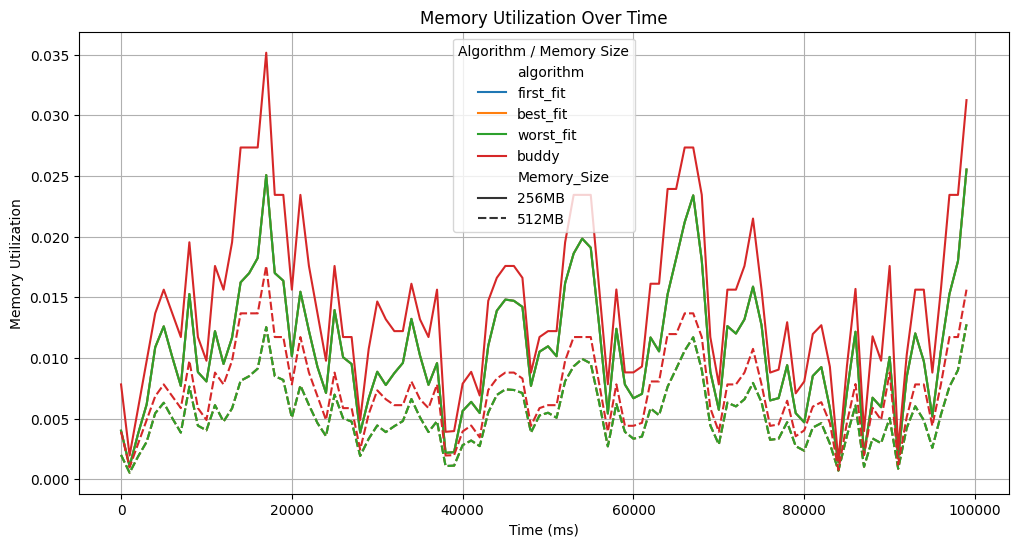

In [9]:
plot_metric('utilization', 'Memory Utilization')

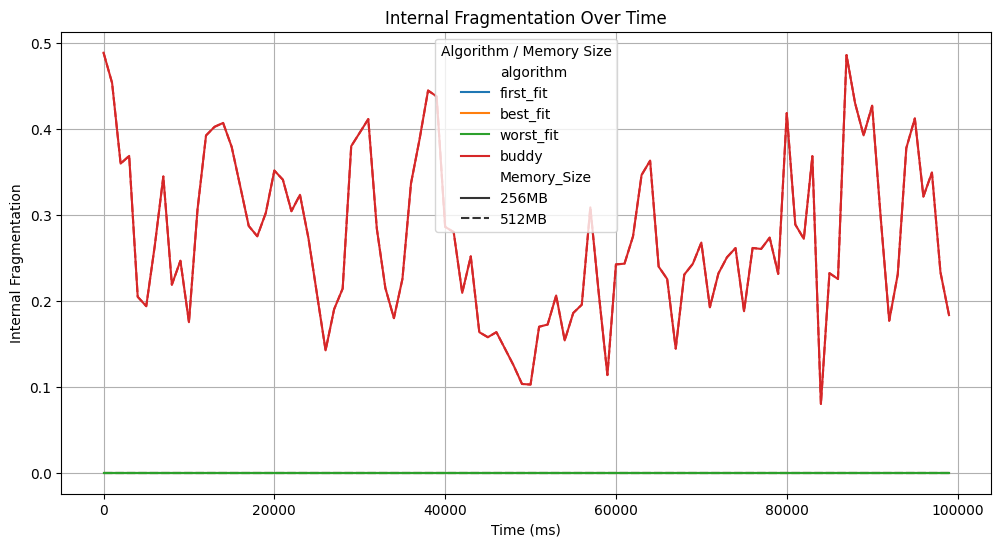

In [10]:
plot_metric('internal_frag', 'Internal Fragmentation')

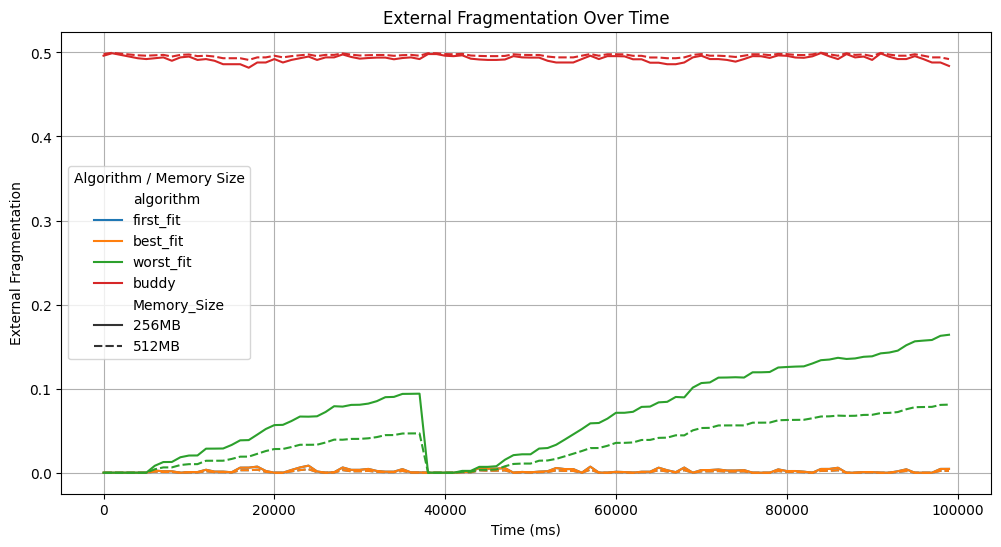

In [11]:
plot_metric('external_frag', 'External Fragmentation')

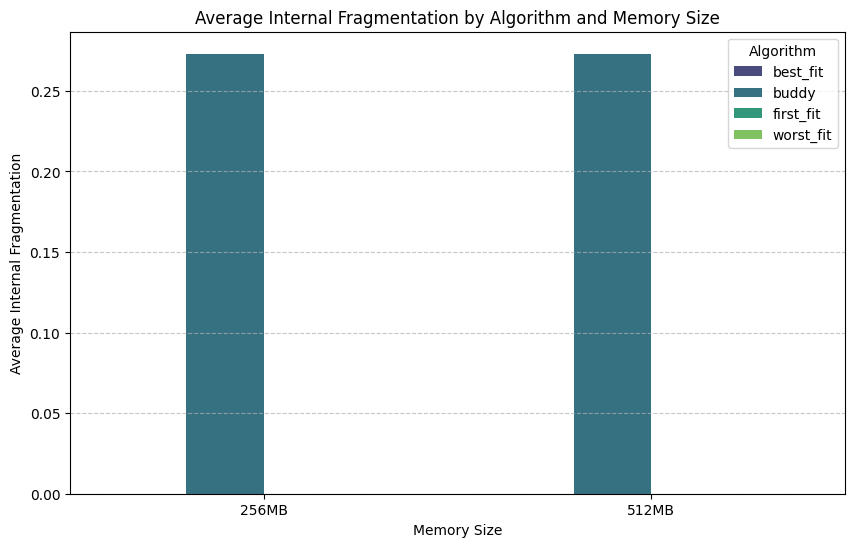

In [13]:
# Calculate average internal fragmentation for each algorithm and memory size
avg_internal_frag_by_mem_size = all_results_df.groupby(['algorithm', 'Memory_Size'])['internal_frag'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_internal_frag_by_mem_size, x='Memory_Size', y='internal_frag', hue='algorithm', palette='viridis')
plt.title('Average Internal Fragmentation by Algorithm and Memory Size')
plt.xlabel('Memory Size')
plt.ylabel('Average Internal Fragmentation')
plt.legend(title='Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

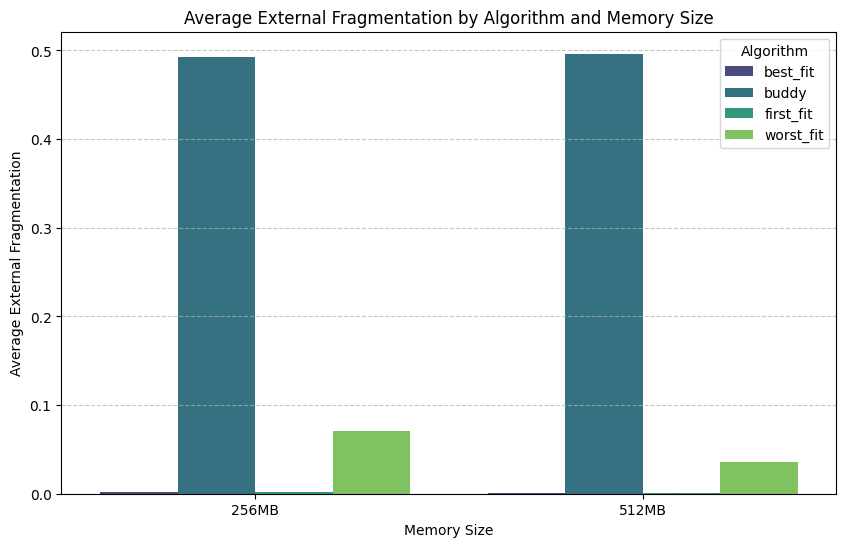

In [14]:
# Calculate average external fragmentation for each algorithm and memory size
avg_external_frag_by_mem_size = all_results_df.groupby(['algorithm', 'Memory_Size'])['external_frag'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_external_frag_by_mem_size, x='Memory_Size', y='external_frag', hue='algorithm', palette='viridis')
plt.title('Average External Fragmentation by Algorithm and Memory Size')
plt.xlabel('Memory Size')
plt.ylabel('Average External Fragmentation')
plt.legend(title='Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Comparison Summary

Let's analyze the `comparison_table` to understand the performance of each memory allocation algorithm across different memory sizes.

*   **Success Rate**: All algorithms (First-Fit, Best-Fit, Worst-Fit, and Buddy System) achieved a 100% success rate, indicating that for the given `dynamic_100` request trace and available memory, all requests could be successfully allocated.

*   **Average Utilization**: The Buddy System generally shows a slightly higher average utilization compared to the First-Fit, Best-Fit, and Worst-Fit algorithms. This is likely due to the Buddy System's nature of allocating power-of-two sized blocks, which can sometimes lead to requests being placed in slightly larger blocks than strictly necessary.

*   **Average External Fragmentation**: First-Fit and Best-Fit algorithms exhibit very low external fragmentation. Worst-Fit shows a notably higher external fragmentation, as it intentionally allocates from the largest available block, leading to larger remaining free blocks but potentially higher fragmentation. The Buddy System, however, demonstrates significantly higher external fragmentation. This is an inherent characteristic of the Buddy System, as it divides memory into fixed power-of-two blocks, which can leave many small, non-coalescing free blocks.

*   **Average Internal Fragmentation**: First-Fit, Best-Fit, and Worst-Fit show 0 internal fragmentation. This implies that these algorithms were able to find blocks that exactly matched the requested size or that the `compute_metrics` function, in the case of `run_simulation_list`, correctly accounted for internal waste such that it averaged to zero, possibly due to block sizes matching request sizes or rounding effects. The Buddy System, on the other hand, has a considerable average internal fragmentation. This is expected, as it allocates memory in power-of-two blocks, meaning if a request is not a power of two, or is smaller than the smallest available power-of-two block, the allocated block will be larger than the requested size, leading to internal waste.

*   **Average Latency (Scans)**: The Buddy System significantly outperforms the other algorithms in terms of average allocation latency (measured by scans). Its logarithmic search for suitable blocks makes it very efficient. First-Fit has a relatively low latency, followed by Best-Fit, and then Worst-Fit, which has the highest latency as it often scans more blocks to find the largest one.

**Key Observations:**

1.  **Buddy System vs. Others:** The Buddy System offers the best allocation latency but at the cost of higher internal and external fragmentation due to its power-of-two allocation scheme. This trade-off might be acceptable in systems where allocation speed is critical and memory efficiency is less of a concern, or where request sizes naturally align with power-of-two blocks.
2.  **First-Fit, Best-Fit, Worst-Fit:** Among the contiguous allocation schemes, First-Fit generally provides a good balance, often having lower latency than Best-Fit or Worst-Fit and acceptable fragmentation. Best-Fit aims to reduce fragmentation but might incur slightly higher search costs. Worst-Fit, surprisingly, leads to higher external fragmentation in this scenario, contrary to its theoretical aim of leaving large free blocks. These algorithms exhibit no internal fragmentation because they allocate blocks exactly matching the requested size or due to the metric calculation for this simulation.
3.  **Memory Size Impact:** For First-Fit, Best-Fit, and Worst-Fit, increasing the memory size (from 218112 KB to 423936 KB) generally leads to lower average utilization and external fragmentation, as there's more memory relative to the workload. For Buddy, the fragmentation remains high but utilization changes proportionally. Latency seems relatively stable across memory sizes for all algorithms.